<a href="https://colab.research.google.com/github/WilliamCollins-a/LLMHallucinations/blob/main/src/SemanticEntropyqa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount Drive

In [ ]:
#Import the 'drive' module from Google Colab to enable access to Google Drive files and
from google.colab import drive
# Mount Google Drive to the Colab environment
drive.mount('/content/drive')


Mounted at /content/drive


Load and execute the model loader and json data file- Which loads the model and QA dataset



In [ ]:
#Import library to read jupyter notebooks.
import nbformat

# Function to load a Jupyter notebook from the path.
def load_notebook(notebook_path):
    with open(notebook_path) as f:
        notebook = nbformat.read(f, as_version=4)
    return notebook

# Function to execute all code cells in a notebook
def execute_code_cells(notebook):
    from IPython import get_ipython
    ipython = get_ipython()
    for cell in notebook.cells:
        if cell.cell_type == 'code':
            ipython.run_cell(cell.source)

# Load and execute code from the notebook
notebook_path = '/content/drive/MyDrive/Colab Notebooks/model_loader.ipynb'
notebook = load_notebook(notebook_path)
execute_code_cells(notebook)

notebook_path = '/content/drive/MyDrive/Colab Notebooks/json_data_loader.ipynb'
notebook = load_notebook(notebook_path)
execute_code_cells(notebook)


Found existing installation: bitsandbytes 0.44.1
Uninstalling bitsandbytes-0.44.1:
  Successfully uninstalled bitsandbytes-0.44.1
Found existing installation: accelerate 1.0.1
Uninstalling accelerate-1.0.1:
  Successfully uninstalled accelerate-1.0.1
  Using cached bitsandbytes-0.44.1-py3-none-manylinux_2_24_x86_64.whl.metadata (3.5 kB)
  Using cached accelerate-1.0.1-py3-none-any.whl.metadata (19 kB)
Using cached bitsandbytes-0.44.1-py3-none-manylinux_2_24_x86_64.whl (122.4 MB)
Using cached accelerate-1.0.1-py3-none-any.whl (330 kB)
Loading the tokenizer...
Loading the model...


model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

Streaming output truncated to the last 5000 lines.
{'knowledge': '"Faster" is the first single from Dutch symphonic metal/rock band Within Temptation\'s album "The Unforgiving". It had its worldwide radio première on 96.3 Rock Radio on 21 January 2011.The Unforgiving is the fifth studio album by Dutch symphonic metal band Within Temptation, released by Roadrunner Records on March 25, 2011. It was a concept album as one part of a transmedia storytelling project.The first single, "Faster", was released on January 21.', 'question': 'What radio station premiered Within Temptation\'s first single "Faster" from their fifth studio album on January 21,2011?', 'right_answer': '96.3 Rock Radio', 'hallucinated_answer': 'Within Temptation\'s first single "Faster" from their fifth studio album was premiered on a local radio station.'}
{'knowledge': 'Michel Dubois (born November 7, 1954) is a Canadian former professional ice hockey player who played in the World Hockey Association (WHA). Dubois play

Generate responses and save to an output file

In [ ]:
# Import Libraries
import os
import json
import random
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import logging

# Configure logging to display information logs
logging.basicConfig(level=logging.INFO)

# Function to generate multiple responses for a given question
def generate_multiple_responses(question, model, tokenizer, num_responses=2, num_generations=3, temp_low=0.7, temp_high=1.2):
    responses = []  # List to store generated responses

    # Ensure pad_token is set
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    # Tokenize the input question and convert to tensor format
    input_ids = tokenizer(question, return_tensors="pt", padding=True).input_ids.to(model.device)

    # Generate multiple responses via loop
    for generation in range(num_generations):
        # Use temp_low for the first iteration, then temp_high for subsequent ones
        temp = temp_low if generation == 0 else temp_high

        for _ in range(num_responses):
            output = model.generate(
                input_ids,  # Input tensor for model
                max_length=150,  # Increased max length for more complete answers
                temperature=temp,  # Adjust temp for creativity of responses
                do_sample=True,  # Enable sampling for more diverse outputs
                pad_token_id=tokenizer.eos_token_id,  # Use eos token for padding
                max_new_tokens=50  # Limit to 50 new tokens for response
            )

            # Decode the generated text and strip out special tokens
            response = tokenizer.decode(output[0], skip_special_tokens=True).strip()

            # Check if the response starts with the question and remove it
            if response.startswith(question):
                response = response[len(question):].strip()

            # Avoid unhelpful or repetitive responses
            if response and len(response) > 5 and not any(phrase in response.lower() for phrase in ["thank you", "please provide"]):
                responses.append(response)
                logging.info('Generated response: %s', response)

    # Filter out duplicate or very similar responses
    filtered_responses = list(set(responses))
    return filtered_responses if filtered_responses else ["Sorry, I do not know the answer."]

# Load your JSON data
input_file = '/content/drive/MyDrive/Colab Notebooks/json_data_loader.ipynb'  # Adjust path accordingly
with open(input_file, 'r') as f:
    notebook_data = json.load(f)

# Extract and execute code cells to get questions
data = []
for cell in notebook_data['cells']:
    if cell['cell_type'] == 'code':
        exec(''.join(cell['source']))
        if 'data' in locals():
            data.extend(data)

# Sample and generate responses
num_samples = 100
num_responses_per_question = 2  # Set to 2 responses per question
num_generations = 3  # Number of generations to run
temp_high = 1.2  # Increased temperature for more creativity

if data:
    sampled_data = random.sample(data, min(num_samples, len(data)))  # Randomly sample a subset of questions

    responses = []  # List to store question-response pairs
    right_answers = []  # List to store right answers for sampled questions

    for item in sampled_data:
        question = item.get('question', '')  # Get the question from the data
        right_answer = item.get('right_answer', '')  # Get the right answer from the data

        if question:
            # Guiding prompt for LLM
            english_prompt = (f"Provide a concise, clear, and factual answer in English to the following question: {question}. "
                              "Do not repeat the question or prompt, add instructions, or include irrelevant details. "
                              "Answer directly and use simple and factual sentences."
                             )

            # Generate responses for the question
            responses_for_question = generate_multiple_responses(
                english_prompt, model, tokenizer, num_responses=num_responses_per_question, num_generations=num_generations, temp_low=0.7, temp_high=temp_high
            )

            # Append the question, right answer, and its generated responses to the list
            responses.append({
                'question': question,
                'responses': responses_for_question,
                'right_answer': right_answer  # Store the right answer
            })
            right_answers.append(right_answer)  # Collect right answers separately

    # Save generated responses to a JSON file
    output_file = '/content/drive/MyDrive/Colab Notebooks/generated_responses1.json'  # Adjust path accordingly
    with open(output_file, 'w') as f:
        json.dump(responses, f, indent=4)

    print(f"Responses saved to {output_file}")
    print("Right Answers Collected:", right_answers)  # Display collected right answers
else:
    print("No data found in the notebook.")


Streaming output truncated to the last 5000 lines.
{'knowledge': ' The city was also called Titograd (Montenegrin Cyrillic: Титоград, ] ) between 1946 and 1992 when Montenegro was part of the Socialist Federal Republic of Yugoslavia (SFRY), in honour of Josip Broz Tito.A capital city (or simply capital) is the municipality exercising primary status in a country, state, province, or other administrative region, usually as its seat of government.', 'question': 'The municipality where the seat of the government of Montenegro was formerly known as what during 1946 and 1992?', 'right_answer': 'Titograd', 'hallucinated_answer': 'The former name of the Montenegro capital is Tito City.'}
{'knowledge': ' Only Vernors Ginger Ale , dating to 1866, is older. It was created in 1866 by James Vernor, a Detroit pharmacist.', 'question': 'Who created the soft drink that is older than Hires Root Beer?', 'right_answer': 'James Vernor', 'hallucinated_answer': 'Hires Root Beer is actually older.'}
{'knowle

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Both `max_new_tokens` (=50) and `max_length`(=150) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


{'knowledge': 'Chronicle is a 2012 American found footage science-fiction thriller film directed by Josh Trank and written by Max Landis based on a story by both. It follows three Seattle high school seniors, bullied Andrew (Dane DeHaan), his cousin Matt (Alex Russell) and more popular Steve (Michael B. Jordan), who form a bond after gaining telekinetic powers from an unknown object.Michael Bakari Jordan (born February 9, 1987) is an American actor. Jordan\'s television roles include Wallace in the critically acclaimed HBO series "The Wire" (2002), Reggie Montgomery in the ABC soap opera "All My Children" (2003–2006), and Vince Howard in the NBC drama series "Friday Night Lights" (2009–2011).', 'question': 'What actor starred in both "The Wire" and "Chronicle"?', 'right_answer': 'Michael B. Jordan', 'hallucinated_answer': 'Some actors have appeared in "The Wire" and "Chronicle".'}
{'knowledge': 'Pineville ( ; locally ) is a suburban town in the southernmost portion of Mecklenburg Count

Both `max_new_tokens` (=50) and `max_length`(=150) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=50) and `max_length`(=150) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=50) and `max_length`(=150) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=50) and `max_length`(=150) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both

Responses saved to /content/drive/MyDrive/Colab Notebooks/generated_responses1.json
Right Answers Collected: ['Miami Indian burial mound.', 'George Franklin Getty', 'Alfred Pennyworth', '1990', 'crowned', 'Aloha Airlines Flight 243', 'Canary Islands, Spain', 'Best Film', 'Demi Lovato', 'software for singing training', 'Leah Ayres', 'Alexander Hamilton', 'Great Exuma', 'Frank Wildhorn', 'Corpse Bride', 'Austrian', 'Cambodia', "The Australian Women's Weekly", 'Florida', '1940', 'Christian Brothers University', 'Australia', 'Mark Dunkerley', 'Huizhou', 'London Academy of Music and Dramatic Art', '115 lb', 'Peace & Harmony', 'yes', 'Sports Illustrated', 'World of Motion', '"hub of the North"', 'Neotribalism', 'Simon Verhoeven', 'August 31, 1935', 'plants', 'Anne Hutchinson', '5.9 sqmi', 'Daniel Bernoulli', 'Saw 3D', 'no', 'Danny Manning', 'LZR Racer', 'Oregon', 'Needtobreathe', 'National Alliance', 'England cricket team', 'Serpent Mound', 'Kabaddi', 'yes', 'E. G. Marshall', 'Air Force, Inc

FINAL CODE - ENTROPY CALCULATION

In [ ]:
import numpy as np
import logging
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
import re

# Initialize the prediction cache
prediction_cache = {}

# Configure logging
logging.basicConfig(level=logging.DEBUG)  # or INFO based on your needs

def load_model_and_tokenizer(model_name="meta-llama/Llama-2-7b-chat-hf"):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name).to("cuda" if torch.cuda.is_available() else "cpu")
    return model, tokenizer


def equivalence_prompt_with_reasoning(text1, text2, question):
    prompt = f"""We are evaluating two answers to the question: "{question}"

    Possible Answer 1: {text1}
    Possible Answer 2: {text2}

    Please evaluate the factual relationship between these two answers.
    Explain your reasoning based on the information provided. After that, determine if the two answers:
    1. Have the same meaning or imply the same fact ("entailment"),
    2. Express opposite or contradictory facts ("contradiction"), or
    3. Do not relate to each other ("neutral").

    Provide reasoning starting with "Reasoning:" and end your response with "Label: [one of entailment, contradiction, neutral]".

    Your response should contain the reasoning followed by one of the labels: "entailment", "contradiction", or "neutral" in full.

    Response:"""
    return prompt

def parse_response(response):
    """Extract reasoning and label from the model's response using regex."""
    response = response.strip()  # Remove surrounding whitespace
    logging.debug("Raw response for parsing: %s", response)

    # Match reasoning which may span multiple lines
    reasoning_match = re.search(r'Reasoning:\s*((?:.|\n)*?)\s*Label:', response, re.IGNORECASE)

    # Match the label, ensuring we capture "entailment", "contradiction", or "neutral"
    label_match = re.search(r'Label:\s*(entailment|contradiction|neutral)', response, re.IGNORECASE)

    if reasoning_match and label_match:
        reasoning = reasoning_match.group(1).strip()  # Capture the reasoning text
        label = label_match.group(1).strip().lower()  # Normalize the label to lowercase
        return reasoning, label
    else:
        logging.warning("Failed to extract reasoning or label correctly from model output.")
        return "Reasoning not found", "neutral"


def predict(prompt, model, tokenizer):
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(model.device)
    output = model.generate(input_ids, max_length=1400, num_return_sequences=1, temperature=0.5)
    response = tokenizer.decode(output[0], skip_special_tokens=True)
    logging.debug("Raw Model Output: %s", response)
    print("Raw Model Output:", response)
    if not response.strip():
        logging.warning("Empty response received from model.")
    return response

def check_implication(text1, text2, model, tokenizer, example=None):
    if example is None:
        raise ValueError("Example must not be None.")

    prompt = equivalence_prompt_with_reasoning(text1, text2, example['question'])  # Fixed here
    logging.info('Input prompt: %s', prompt)

    cache_key = (text1, text2, example['question'])
    hashed = hash(cache_key)

    if hashed in prediction_cache:
        logging.info('Restoring cached prediction.')
        response = prediction_cache[hashed]
    else:
        response = predict(prompt, model, tokenizer)
        prediction_cache[hashed] = response

    logging.info('Raw Model Output: %s', response)

    reasoning, label = parse_response(response)

    return reasoning, label

def are_equivalent(text1, text2, model, tokenizer, example):
    # Check implication both ways
    reasoning1, label1 = check_implication(text1, text2, model, tokenizer, example)
    reasoning2, label2 = check_implication(text2, text1, model, tokenizer, example)

    logging.debug(f"Comparing: '{text1}' with '{text2}' - Labels: {label1}, {label2}")

    if label1 == 'entailment' and label2 == 'entailment':
        return True, reasoning1  # Both entail each other
    elif label1 == 'contradiction' and label2 == 'contradiction':
        return False, None  # Both contradict each other, should not be grouped
    elif label1 == 'neutral' and label2 == 'neutral':
        return False, None  # Both neutral, should not be grouped
    return False, None  # Any other case leads to not being equivalent

def get_semantic_ids(responses, model, tokenizer, example=None):
    semantic_set_ids = [-1] * len(responses)  # Initialize all IDs to -1
    next_id = 0  # ID counter
    labels = [None] * len(responses)  # Initialize labels list

    for i, response1 in enumerate(responses):
        if semantic_set_ids[i] == -1:  # If response1 has no ID yet
            semantic_set_ids[i] = next_id  # Assign current ID
            logging.info(f"Assigning new semantic ID {next_id} to response {i}: '{response1}'")
            print(f"Assigning ID {next_id} to response: {response1}")
            for j in range(i + 1, len(responses)):
                if semantic_set_ids[j] == -1:
                    equivalent, reasoning = are_equivalent(response1, responses[j], model, tokenizer, example)
                    if equivalent:
                        semantic_set_ids[j] = next_id  # Assign same ID to equivalent responses
                        logging.info(f"Assigning semantic ID {next_id} to equivalent response {j}: '{responses[j]}'")
                        print(f"Assigning ID {next_id} to equivalent response: {responses[j]}")
                        labels[j] = reasoning  # Store reasoning for equivalent responses
            next_id += 1  # Move to the next ID for the next unique group

    logging.info(f"Final assigned semantic_set_ids: {semantic_set_ids}")
    print(f"Assigned semantic_set_ids: {semantic_set_ids}")
    return semantic_set_ids, labels

def remap_semantic_ids(semantic_ids):
    """Ensure semantic IDs are continuous and remap them."""
    unique_ids = {id: idx for idx, id in enumerate(sorted(set(semantic_ids))) if id != -1}
    remapped_ids = [unique_ids.get(id, -1) for id in semantic_ids]
    logging.info(f"Remapped semantic_ids: {remapped_ids}")
    return remapped_ids

def cluster_assignment_entropy(semantic_ids):
    """Calculate the entropy of the cluster assignments."""
    n_generations = len(semantic_ids)
    counts = np.bincount(semantic_ids)
    probabilities = counts / n_generations
    return -np.sum(probabilities * np.log(probabilities + 1e-10))

def logsumexp_by_id(semantic_ids, log_likelihoods):
    """Compute logsumexp for each semantic group."""
    unique_ids = sorted(set(semantic_ids))
    log_likelihood_per_semantic_id = []

    for uid in unique_ids:
        id_indices = [pos for pos, x in enumerate(semantic_ids) if x == uid]
        id_log_likelihoods = [log_likelihoods[i] for i in id_indices]

        if id_log_likelihoods:  # Check if list is not empty
            logsumexp_value = np.log(np.sum(np.exp(id_log_likelihoods)))
            log_likelihood_per_semantic_id.append(logsumexp_value)

    return log_likelihood_per_semantic_id

def predictive_entropy(log_probs):
    """Calculate predictive entropy from log probabilities."""
    probabilities = np.exp(log_probs)
    entropy = -np.sum(probabilities * np.log(probabilities + 1e-10))
    return entropy

# Load model and tokenizer
model, tokenizer = load_model_and_tokenizer()

# Load generated responses from JSON
input_file = '/content/drive/MyDrive/Colab Notebooks/generated_responses1.json'  # Adjust path accordingly
with open(input_file, 'r') as f:
    responses_data = json.load(f)

# Update the section where semantic IDs and labels are assigned
for item in responses_data:
    question = item['question']
    responses_for_question = item['responses']

    # Get semantic IDs and labels
    semantic_ids, labels = get_semantic_ids(responses_for_question, model, tokenizer, example={'question': question})

    # Remap semantic_ids to ensure they are continuous
    semantic_ids = remap_semantic_ids(semantic_ids)

    # Compute log likelihoods based on uniform distribution
    num_responses = len(responses_for_question)
    log_likelihoods = [torch.log(torch.tensor(1.0 / num_responses))] * num_responses

    # Calculate entropy
    cluster_entropy = cluster_assignment_entropy(semantic_ids)
    log_likelihood_per_semantic_id = logsumexp_by_id(semantic_ids, log_likelihoods)

    # Calculate predictive entropy
    predictive_entropies = [predictive_entropy(likelihood) for likelihood in log_likelihood_per_semantic_id]

    # Store results
    item['semantic_ids'] = semantic_ids
    item['cluster_entropy'] = cluster_entropy
    item['predictive_entropies'] = predictive_entropies

# Save updated responses data with semantic IDs and entropies to JSON
output_file = '/content/drive/MyDrive/Colab Notebooks/semantic_entropy7.json'  # Adjust path accordingly
with open(output_file, 'w') as f:
    json.dump(responses_data, f, indent=4)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
    3. Do not relate to each other ("neutral").

    Provide reasoning starting with "Reasoning:" and end your response with "Label: [one of entailment, contradiction, neutral]".

    Your response should contain the reasoning followed by one of the labels: "entailment", "contradiction", or "neutral" in full.

    Response:

Reasoning: Both answers mention Michael Doret as the designer and illustrator for a movie produced by Walt Disney Animation Studios. Both answers also specify the name of the movie, although they differ in the specific movie mentioned.

Possible Answer 1 states that Michael Doret designed and illustrated characters for "The Lion King", while Possible Answer 2 states that he designed and illustrated characters for "Beauty and the Beast".

Label: entailment
Raw Model Output: We are evaluating two answers to the question: "Michael Doret is known for being a designer and illustrator for what movie produced by Walt Disn

METRICS

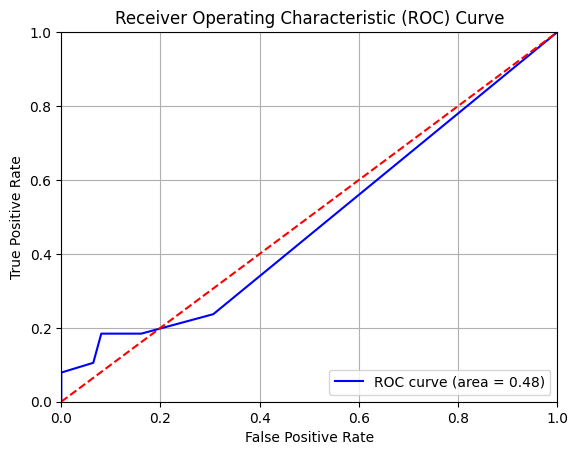

AUC: 0.48


In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Load the JSON files
def load_json_file(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

# Load both files
entropy_data = load_json_file('/content/drive/MyDrive/Colab Notebooks/semantic_entropy7.json')
answers_data = load_json_file('/content/drive/MyDrive/Colab Notebooks/generated_responses1.json')

# Initialize lists to store true labels and predicted probabilities
y_true = []  # True labels: 1 for correct, 0 for incorrect
y_scores = []  # Predicted probabilities (or scores)

# Create a dictionary to map questions to their correct answers
answers_dict = {item['question']: item['right_answer'] for item in answers_data}

# Analyze the entropy data
for item in entropy_data:
    question = item['question']
    correct_answer = answers_dict.get(question)

    # Check if the correct answer is available for the current question
    if correct_answer:
        # Check if the correct answer is in any of the responses
        is_correct = any(correct_answer in response for response in item['responses'])

        # Append true label (1 for correct, 0 for incorrect)
        y_true.append(1 if is_correct else 0)

        # Append the entropy value as the predicted score
        y_scores.append(item['cluster_entropy'])

# Ensure the lists are numpy arrays
y_true = np.array(y_true)
y_scores = np.array(y_scores)

# Check if we have enough data to calculate AUC-ROC
if len(np.unique(y_true)) > 1 and len(y_true) > 1:
    # Calculate the ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Plotting the ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    # Print the AUC value
    print(f'AUC: {roc_auc:.2f}')
else:
    print("Insufficient data to compute AUC-ROC.")


In [ ]:
import json
import numpy as np
from sklearn.metrics import accuracy_score

# Load the JSON files
def load_json_file(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

# Load both files
entropy_data = load_json_file('/content/drive/MyDrive/Colab Notebooks/semantic_entropy7.json')
answers_data = load_json_file('/content/drive/MyDrive/Colab Notebooks/generated_responses1.json')

# Initialize lists to store true labels and predicted labels
y_true = []  # True labels: 1 for correct, 0 for incorrect
y_pred = []  # Predicted labels: 1 for correct, 0 for incorrect based on entropy threshold

# Create a dictionary to map questions to their correct answers
answers_dict = {item['question']: item['right_answer'] for item in answers_data}

# Set a threshold value for entropy to classify a response as correct or incorrect
# You might need to experiment with different threshold values
entropy_threshold = 0.5  # Example threshold, adjust based on your needs

# Analyze the entropy data
for item in entropy_data:
    question = item['question']
    correct_answer = answers_dict.get(question)

    # Check if the correct answer is available for the current question
    if correct_answer:
        # Check if the correct answer is in any of the responses
        is_correct = any(correct_answer in response for response in item['responses'])

        # Append true label (1 for correct, 0 for incorrect)
        y_true.append(1 if is_correct else 0)

        # Determine if the predicted response is correct based on entropy threshold
        predicted_correct = 1 if item['cluster_entropy'] <= entropy_threshold else 0

        # Append the predicted label
        y_pred.append(predicted_correct)

# Ensure the lists are numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate accuracy score
accuracy = accuracy_score(y_true, y_pred)

# Print the accuracy
print(f'Accuracy: {accuracy * 100:.2f}%')


Accuracy: 41.00%
